In [1]:
import procaliper as pc
import procaliper.network as pn
import procaliper.view as pcv

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from nglview.color import ColormakerRegistry
from os.path import exists

In [2]:
fields = pc.Protein.UNIPROT_API_DEFAULT_FIELDS
fields += ["ft_mod_res", "ft_region"]
protein = pc.Protein.from_uniprot_id("P07900")
if exists("P07900.pdb"):
    protein.register_local_pdb(path_to_pdb_file="P07900.pdb")
else:
    print("PDB file not found, fetching from UniProt...")
    protein.fetch_pdb(save_path="P07900.pdb")

Fetched: 1 / 1


In [3]:
protein.get_sasa()  # compute and store the values
assert protein.sasa_data is not None

sasa_scheme = pcv.ngl_scheme(
    protein.sasa_data["all_sasa_value"]
)  # create a color scheme from the values

view = pcv.protein_to_nglview(protein)  # generate an nglview widget

view.stage.set_parameters(
    **{
        "fogFar": 1000,
    }
)

view._remove_representation()  # remove the default representation

ColormakerRegistry.add_selection_scheme(
    "all_sasa_value", sasa_scheme
)  # add our color scheme to nglview
view.add_representation(
    "cartoon", color="all_sasa_value"
)  # render the protein using our color scheme
view.control.spin(np.array([-1, 1, 0]) / np.sqrt(2), np.pi / 2)
view

NGLWidget()

In [4]:
im = view.render_image(
    trim=True
)  # adjust the rotation, etc. of the view above before rendering
display(im)

Image(value=b'', width='99%')

In [5]:
with open("P07900_sasa.png", "wb") as f:
    f.write(im.value)  # must display image above before saving

In [6]:
protein.get_charge()  # compute and store values
assert protein.charge_data is not None

residue_charges = [sum(x) for x in protein.charge_data["charge"]]

charge_scheme = pcv.ngl_scheme(
    residue_charges, two_sided=True
)  # create a color scheme from the values

view = pcv.protein_to_nglview(protein)  # generate an nglview widget

view.stage.set_parameters(
    **{
        "fogFar": 1000,
    }
)

view._remove_representation()  # remove the default representation

ColormakerRegistry.add_selection_scheme(
    "charge_value", charge_scheme
)  # add our color scheme to nglview
view.add_representation(
    "surface", color="charge_value"
)  # render the protein using our color scheme
view.control.spin(np.array([-1, 1, 0]) / np.sqrt(2), np.pi / 2)
view

NGLWidget()

In [7]:
im = view.render_image(
    trim=True
)  # adjust the rotation, etc. of the view above before rendering
display(im)

Image(value=b'', width='99%')

In [8]:
with open("P07900_charge.png", "wb") as f:
    f.write(im.value)  # must display image above before saving

In [9]:
protein.get_titration()
assert protein.titration_data is not None


pka_values = [x - 7 if x is not None else 0 for x in protein.titration_data["pKa"]]
pka_scheme = pcv.ngl_scheme(pka_values, two_sided=True)  # create a color scheme

view = pcv.protein_to_nglview(protein)  # generate an nglview widget

view.stage.set_parameters(
    **{
        "fogFar": 1000,
    }
)

view._remove_representation()  # remove the default representation

ColormakerRegistry.add_selection_scheme(
    "pKa", pka_scheme
)  # add our color scheme to nglview
view.add_representation(
    "ball+stick", color="pKa"
)  # render the protein using our color scheme
view.control.spin(np.array([-1, 1, 0]) / np.sqrt(2), np.pi / 2)
view

NGLWidget()

In [10]:
im = view.render_image(
    trim=True
)  # adjust the rotation, etc. of the view above before rendering
display(im)

Image(value=b'', width='99%')

In [11]:
with open("P07900_pKa.png", "wb") as f:
    f.write(im.value)  # must display image above before saving

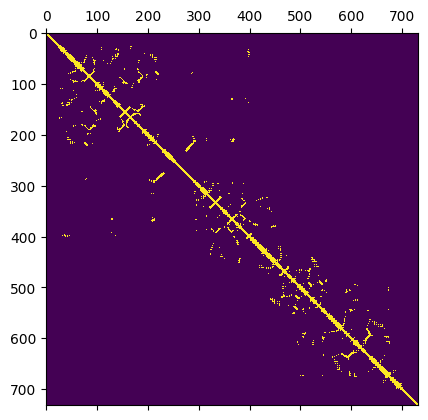

In [ ]:
contact_map = nx.to_numpy_array(
    pn.contact_network(protein)  # default max_dist_angstroms=10
)
plt.matshow(contact_map, interpolation="none")
plt.show()

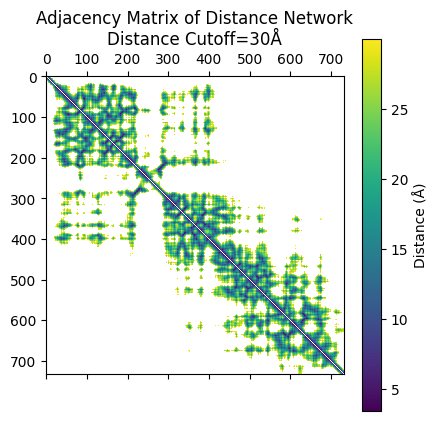

In [28]:
max_dist_angstroms = 30
dm = pn.distance_network(
    protein, max_dist_angstroms=max_dist_angstroms
)  # max_dist_angstroms=20 is the default
plt.matshow(nx.to_numpy_array(dm, nonedge=np.nan), interpolation="none")
plt.colorbar(label="Distance (Å)")
plt.title(
    f"Adjacency Matrix of Distance Network\nDistance Cutoff={max_dist_angstroms}Å"
)
plt.show()

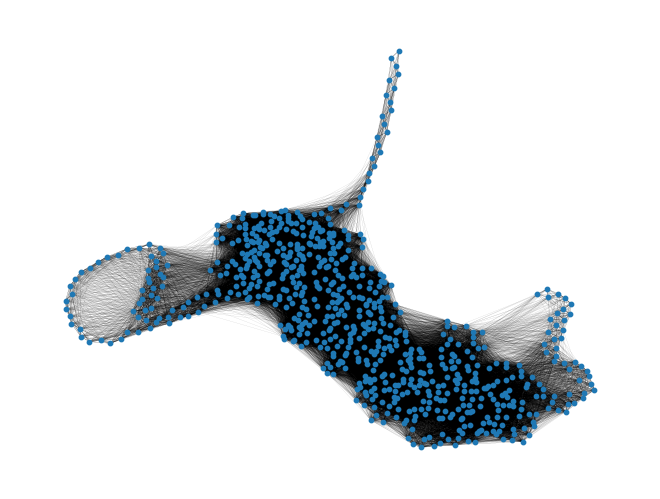

In [29]:
nx.draw(
    dm,
    pos=nx.layout.kamada_kawai_layout(dm),
    node_size=10,
    width=[d["proximity"] for _, _, d in dm.edges(data=True)],
)

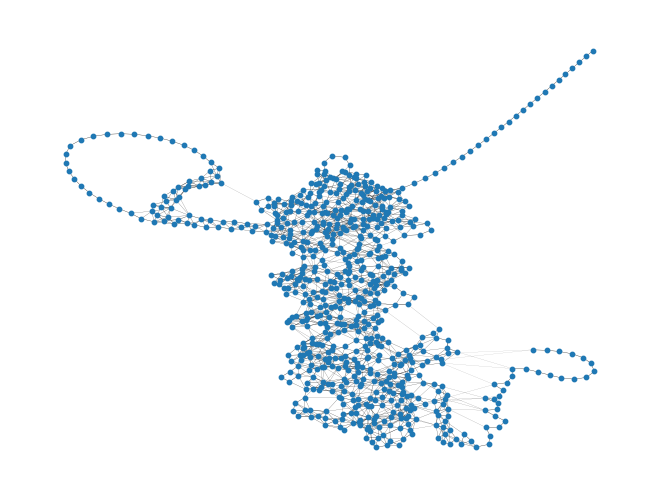

In [30]:
dm_bb = pn.euclidean_backbone(dm)
nx.draw(
    dm_bb,
    pos=nx.layout.kamada_kawai_layout(dm_bb),
    node_size=10,
    width=[d["proximity"] for _, _, d in dm_bb.edges(data=True)],
)

In [31]:
dm_bb.number_of_edges() / dm.number_of_edges()

0.032840603978404596

In [32]:
reg = pn.regulatory_distance_network(protein)

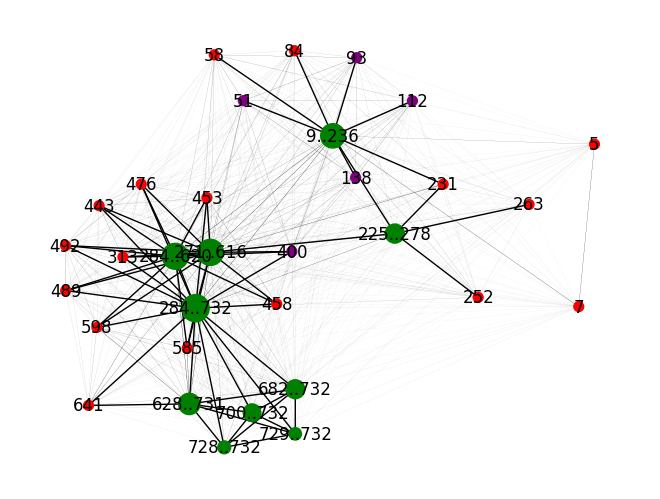

In [48]:
region_type_colors = {
    "PTM site": "red",
    "binding site": "purple",
    "active site": "cyan",
    "annotated region": "green",
}
nx.draw(
    reg,
    pos=nx.layout.spring_layout(
        reg,
        weight="proximity",
        k=10,
        iterations=1000,
        seed=0,
    ),
    node_size=[50 * len(d["residues"]) ** (1 / 3) for _, d in reg.nodes(data=True)],
    width=[d["proximity"] for _, _, d in reg.edges(data=True)],
    labels=nx.get_node_attributes(reg, "label"),
    node_color=[region_type_colors[d["region_type"]] for _, d in reg.nodes(data=True)],
)

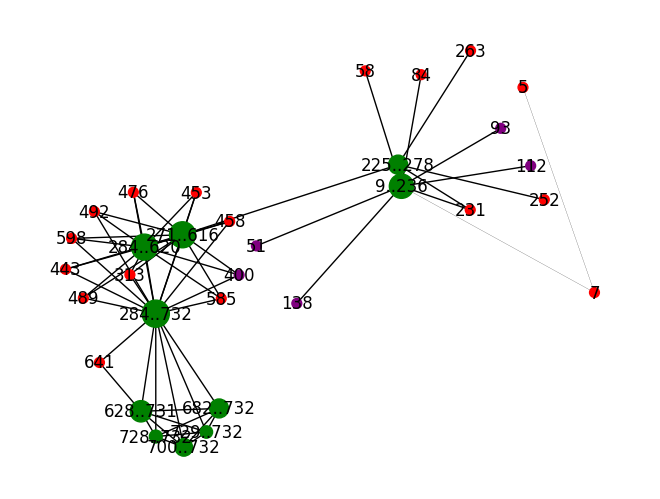

In [49]:
reg_bb = pn.euclidean_backbone(reg)
nx.draw(
    reg_bb,
    pos=nx.layout.spring_layout(
        reg_bb,
        weight="proximity",
        k=10,
        iterations=1000,
        seed=0,
    ),
    node_size=[50 * len(d["residues"]) ** (1 / 3) for _, d in reg_bb.nodes(data=True)],
    width=[d["proximity"] for _, _, d in reg_bb.edges(data=True)],
    labels=nx.get_node_attributes(reg, "label"),
    node_color=[
        region_type_colors[d["region_type"]] for _, d in reg_bb.nodes(data=True)
    ],
)